In [2]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import seaborn as sns
%matplotlib inline

## Define functions to rotate velocities

In [3]:
import math

def rotate(x,y,xo,yo,theta): #rotate x,y around xo,yo by theta (rad)
    xr=math.cos(theta)*(x-xo)-math.sin(theta)*(y-yo)   + xo
    yr=math.sin(theta)*(x-xo)+math.cos(theta)*(y-yo)  + yo
    return [xr,yr]

In [4]:
fname = '/home/z3526974/Work/data/dipole_work/IMOS_altimetry_EAC_region_1993_2019/IMOS_aggregation_20190307T030559Z.nc'
ds = xr.open_dataset(fname)
# interpolate to daily
ds = ds.resample(TIME='1D').interpolate('linear')

## Define line for Hovmoller 

In [5]:
start_lon = 154
start_lat = -31

end_lon = 150.6
end_lat = -36.4

#make array of lats and lons for slicing
path_lats=np.linspace(start_lat,end_lat, 25)
path_lons=np.linspace(start_lon,end_lon, 25)

## Extract section along this line for Hovmoller

In [6]:
# use xarray advanced interpolation interp - can't seem to do this pairwise for latlon pairs, for the moment doing it in a loop
section = []
for x in range(25):
    px = ds.sel(LATITUDE=path_lats[x], LONGITUDE=path_lons[x],method = 'nearest') 
    section.append(px)
sec = xr.concat(section, dim=path_lats)

    

ang = np.deg2rad(27)
#rotate velocities normal to section
[u_rot, v_rot]=rotate(sec.UCUR,sec.VCUR,0,0, ang) 


## Plot Hovmoller to see what we're dealing with

Text(0.5,0,'Year')

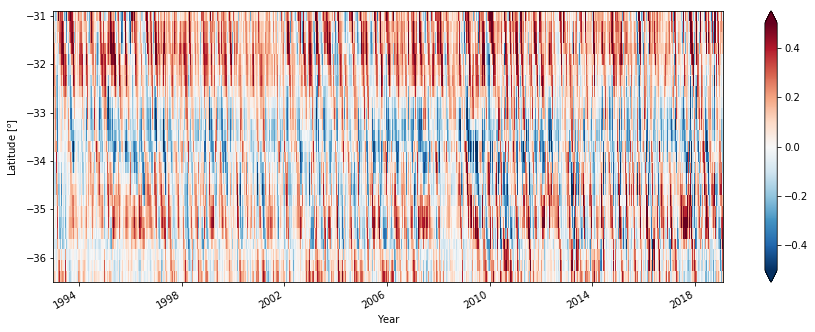

In [7]:
plt.figure(figsize=(15, 5))
u_rot.plot(vmin=-.5,vmax=.5,cmap='RdBu_r')
plt.ylabel('Latitude [$^o$]')
plt.xlabel('Year')

In [8]:
u_rot.concat_dim

<xarray.DataArray 'concat_dim' (concat_dim: 25)>
array([-31.   , -31.225, -31.45 , -31.675, -31.9  , -32.125, -32.35 , -32.575,
       -32.8  , -33.025, -33.25 , -33.475, -33.7  , -33.925, -34.15 , -34.375,
       -34.6  , -34.825, -35.05 , -35.275, -35.5  , -35.725, -35.95 , -36.175,
       -36.4  ])
Coordinates:
    LONGITUDE   (concat_dim) float32 154.0 153.8 153.8 ... 150.8 150.8 150.6
    LATITUDE    (concat_dim) float32 -31.0 -31.2 -31.4 ... -36.0 -36.2 -36.4
  * concat_dim  (concat_dim) float64 -31.0 -31.23 -31.45 ... -35.95 -36.17 -36.4

# Slice and get mean onshore velocity between 33S and 34S

In [9]:
onshore_core = u_rot.sel(concat_dim=slice(-33,-34))

In [10]:
core_tseries = onshore_core.mean(axis=0)

# save as netdcf for checking in matlab
new_filename = 'EAC_xshelf_u_curr_geostrophic_33S_34S_1993_2019.nc'
core_tseries.to_netcdf(path=new_filename)

<function matplotlib.pyplot.show>

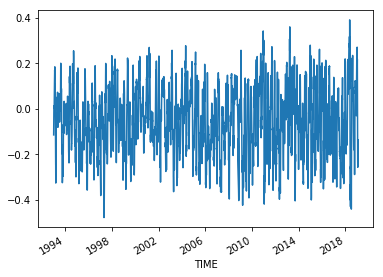

In [11]:
core_tseries.plot()
plt.show

## Plot individual year

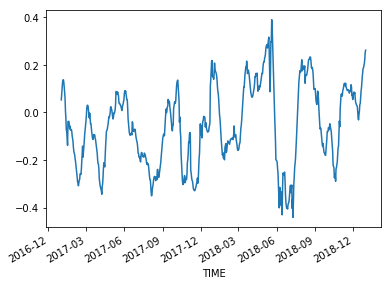

In [14]:
core_tseries.sel(TIME=slice('2017-01-01', '2018-12-31')).plot()

## Calculate Spectra using xscale

In [24]:
import xscale.spectral.fft as xfft

In [25]:
core_time_spectrum = xfft.fft(core_tseries, dim='TIME', dx=1., detrend='mean',
   ...: tapering=True)

core_time_psd = xfft.ps(core_time_spectrum)
core_time_psd

<xarray.DataArray 'PS_spectrum' (f_TIME: 4767)>
dask.array<shape=(4767,), dtype=float64, chunksize=(4767,)>
Coordinates:
  * f_TIME   (f_TIME) float64 0.0 0.0001049 0.0002098 ... 0.4998 0.4999 0.5
Attributes:
    description:  Power Spectrum (PS)

## Plot PSD

In [26]:
from xscale.spectral.tools import plot_spectrum

Text(0,0.5,'PSD')

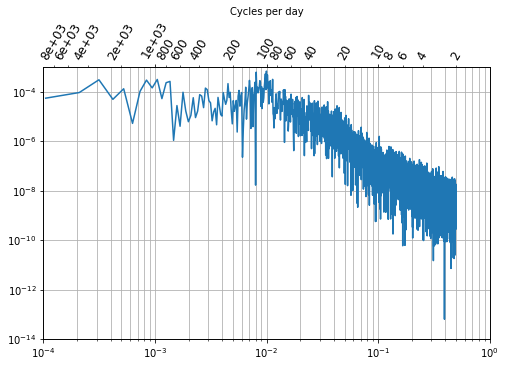

In [27]:
plt.figure(figsize=(8, 5))
plot_spectrum(core_time_psd, loglog=True)
plt.xlabel('Cycles per day')
plt.ylabel('PSD')

## Calculate spectra using the 'Spectrum' package 